In [5]:
import numpy as np
import pandas as pd
import time
import math
import matplotlib.pyplot as plt
import seaborn as sns
from decimal import Decimal

In [154]:
def sim_plasticity_evo(pop_size_init = 500, num_generations = 400, r0 = 2.15, b_init = 0.25, x_init = 9.0, beta = 1.0, K = 1000, v = None, v_array = None, omegaB = 9.0, omegaZ = 25.0, sigmaB = 1.0, sigmaX = 1.0, sigmaE = 1.0):
    # Reaction Norm Arrays
    x_trait = np.zeros(num_generations) # intercept
    b_trait = np.zeros(num_generations) # slope
    z_trait = np.zeros(num_generations) # slope
    # Population Size Array
    population_size = np.zeros(num_generations)

    # Fitness Parameters
    mean_fitness = np.zeros(num_generations-1)
    cost = np.zeros(num_generations-1)
    fitBar = np.zeros(num_generations-1)

    x_trait[0] = x_init
    b_trait[0] = b_init
    population_size[0] = pop_size_init
    
    generations = 0

    for t in range(0,num_generations-1):
        if v is not None:
            eta = 10 + (v * t)
        elif v_array is not None:
            eta = 10 + v_array[t]
        theta = beta * eta


        if t == 0:
            z = x_trait[t] + b_trait[0] * eta
            z_trait[t] = z


        if population_size[t] <= 0:
            break
        generations += 1
        ##### Calculation Population
        ##### Changes
        rZero = r0**( 1 - (population_size[t] / K) )

        # cBar Calculations
        gammaB = 1/( (omegaB) + (sigmaB) )

        cBar = np.sqrt( gammaB*(omegaB) ) * ( np.exp( -(gammaB / 2) * b_trait[0]**2) )
        cost[t] = cBar
        # wBar Calculations

        # Assemble the Stars
        kappa = gammaB*sigmaB
        bStar = (1-kappa)*b_trait[t]
        sigmaBstar = (1-kappa) * sigmaB
        sigmaZstar = sigmaX + ( sigmaB * (eta**2) ) + sigmaE

        #### Expressed  Trait #####
        zStar = x_trait[t] + bStar * theta
        #### Possible Change to conditional based on limited range ####

        gammaZ = 1/( (omegaZ) + (sigmaZstar) ) 

        wBar = np.sqrt( gammaZ * (omegaZ) ) * np.exp( -(gammaZ/2) * (zStar - theta)**2 )
        fitBar[t] = wBar
        # rBar Calculations

        rBar = rZero*wBar*cBar
        mean_fitness[t] = rBar

        # Assigning New Population Size
        population_size[t+1] = math.floor(rBar * population_size[t])

        ##### Calculation Mean Trait ######
        ##### Changes

        # Change in intecept quantity 
        dx = -gammaZ * ( ( x_trait[t] + (bStar * theta) ) - (beta * theta) ) * sigmaX

        # Change in slope quantity 
        db = bStar - b_trait[t] - ( sigmaBstar * ( gammaZ * theta ) * ( x_trait[t] + (bStar * theta) - (beta * theta) ) )

        # Change in mean phenotype

        x_trait[t+1] = x_trait[t] + dx

        b_trait[t+1] = b_trait[t] + db

        zStar_mean = x_trait[t] + (bStar*eta)
        z_trait = zStar_mean
    return population_size, mean_fitness, x_trait, b_trait, generations, cost, fitBar
                    


In [252]:
# arrays for evaluating environemental change 
env_rates = np.logspace(-4,0,50)
b_rates = np.logspace(-5,0,50)
b_rates

array([1.00000000e-05, 1.26485522e-05, 1.59985872e-05, 2.02358965e-05,
       2.55954792e-05, 3.23745754e-05, 4.09491506e-05, 5.17947468e-05,
       6.55128557e-05, 8.28642773e-05, 1.04811313e-04, 1.32571137e-04,
       1.67683294e-04, 2.12095089e-04, 2.68269580e-04, 3.39322177e-04,
       4.29193426e-04, 5.42867544e-04, 6.86648845e-04, 8.68511374e-04,
       1.09854114e-03, 1.38949549e-03, 1.75751062e-03, 2.22299648e-03,
       2.81176870e-03, 3.55648031e-03, 4.49843267e-03, 5.68986603e-03,
       7.19685673e-03, 9.10298178e-03, 1.15139540e-02, 1.45634848e-02,
       1.84206997e-02, 2.32995181e-02, 2.94705170e-02, 3.72759372e-02,
       4.71486636e-02, 5.96362332e-02, 7.54312006e-02, 9.54095476e-02,
       1.20679264e-01, 1.52641797e-01, 1.93069773e-01, 2.44205309e-01,
       3.08884360e-01, 3.90693994e-01, 4.94171336e-01, 6.25055193e-01,
       7.90604321e-01, 1.00000000e+00])

In [109]:
# Create time series data
env_rates = np.logspace(1, -4, 7)
time1 = np.linspace(0, population_size.size - 1, population_size.size)
time2 = np.linspace(0, population_size.size-2, population_size.size - 1)
logar = np.logspace(-1, 4, 21)

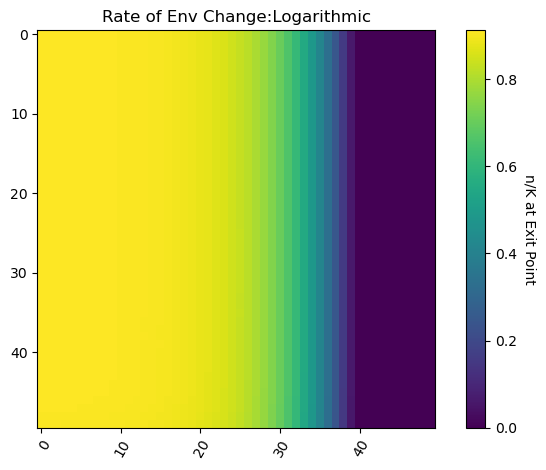

In [253]:
start_time = time.time()
final_pop = np.zeros((b_rates.size,b_rates.size), dtype = float)
for i in range(b_rates.size):
        for j in range(b_rates.size):
            population_size, mean_fitness, x_trait, b_trait, generations, cost, fitBar = sim_plasticity_evo(
                pop_size_init = 5000,
                num_generations = 400,
                r0 = 4.48, # Upper limmit of per capita reproduction 
                b_init = b_rates[i], # init slope of reaction norm
                x_init = 10.0, # init intercept of reaction norm
                beta = 0.5, # environmental sensetivity of phenotypic selection
                K = 5000, # carrying capacity
                v = env_rates[j], # slope of environmental variables
                omegaB = 50, # width of fitness function describing the stabilizing selection on 
                omegaZ = 100, # width of fitness function describing the stabilizing selection on trait z
                sigmaB = 0.25, #
                sigmaX = 0.25, #
                sigmaE = 0.5  #
                )
            final_pop[i,j] = (population_size[generations])/(5000)
heatmap_omegas(logar, final_pop, "Logarithmic")



In [214]:
def heatmap_omegas(logar, final_pop, e_rate):
    labS = []
    for i in range(logar.size):
        labS.append('%.2E' % Decimal(str(logar[i])))
    
    ax = plt.gca()
    im = ax.imshow(final_pop)
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("n/K at Exit Point", rotation=-90, va="bottom")
    #ax.set_xticks(np.arange(len(labS)), labels = labS )
    #ax.set_yticks(np.arange(len(labS)), labels = labS )
    plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
             rotation_mode="anchor")
    ax.set_title("Rate of Env Change:" + str(e_rate))
    plt.tight_layout()
    plt.show()

In [199]:
# sigmoidal for v_array with inversion midpoint 200 generations
x = np.linspace(0, 399, 400)
x = 5 / (1 + np.exp(-0.05 * (x - 200 )) )

In [185]:
# logarithmic for v_array
x = np.linspace(1, 400, 400)
x = ((0.5) * (np.log(x))) * 1.665

In [196]:
def plot_quad(population_size, mean_fitness, x_trait, b_trait):
    r0 = 2.15
    # Create time series data
    time1 = np.linspace(0, population_size.size - 1, population_size.size)
    time2 = np.linspace(0, population_size.size-2, population_size.size - 1)

    # Create subplots
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

    # Create lineplots for each subplot
    sns.lineplot(x=time1, y=population_size, ax=axes[0, 0])
    sns.lineplot(x=time2, y=mean_fitness, ax=axes[0, 1])
    sns.lineplot(x=time1, y=x_trait, ax=axes[1, 0])
    sns.lineplot(x=time1, y=b_trait, ax=axes[1, 1])
    #sns.lineplot(x=time2, y=cost, ax=axes[1, 0])
    #sns.lineplot(x=time2, y=fitBar, ax=axes[1, 1])

    # Edit axis labels
    axes[0, 0].set_xlabel('Time')
    axes[0, 0].set_ylabel('Population Size')
    axes[0, 1].set_xlabel('Time')
    axes[0, 1].set_ylabel('Mean Fitness')
    axes[1, 0].set_xlabel('Time')
    axes[1, 0].set_ylabel('Addative Genetic Effect')
    #axes[1, 0].set_ylabel('Plasticity Cost')
    axes[1, 1].set_xlabel('Time')
    axes[1, 1].set_ylabel('Slope of Reaction Norm')
    #axes[1, 1].set_ylabel('Stabilizing Delection')

    # Show plot
    #plt.show()


In [193]:
plasticity_values = np.logspace(-1, 1, num = 20)
plasticity_values

array([ 0.1       ,  0.1274275 ,  0.16237767,  0.20691381,  0.26366509,
        0.33598183,  0.42813324,  0.54555948,  0.6951928 ,  0.88586679,
        1.12883789,  1.43844989,  1.83298071,  2.33572147,  2.97635144,
        3.79269019,  4.83293024,  6.15848211,  7.8475997 , 10.        ])

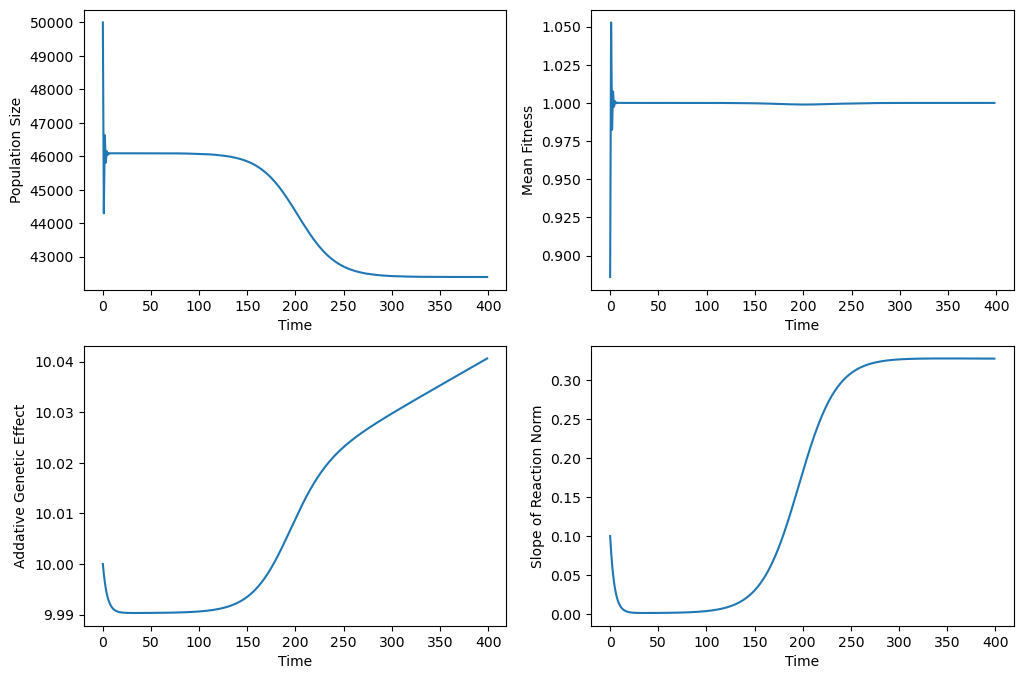

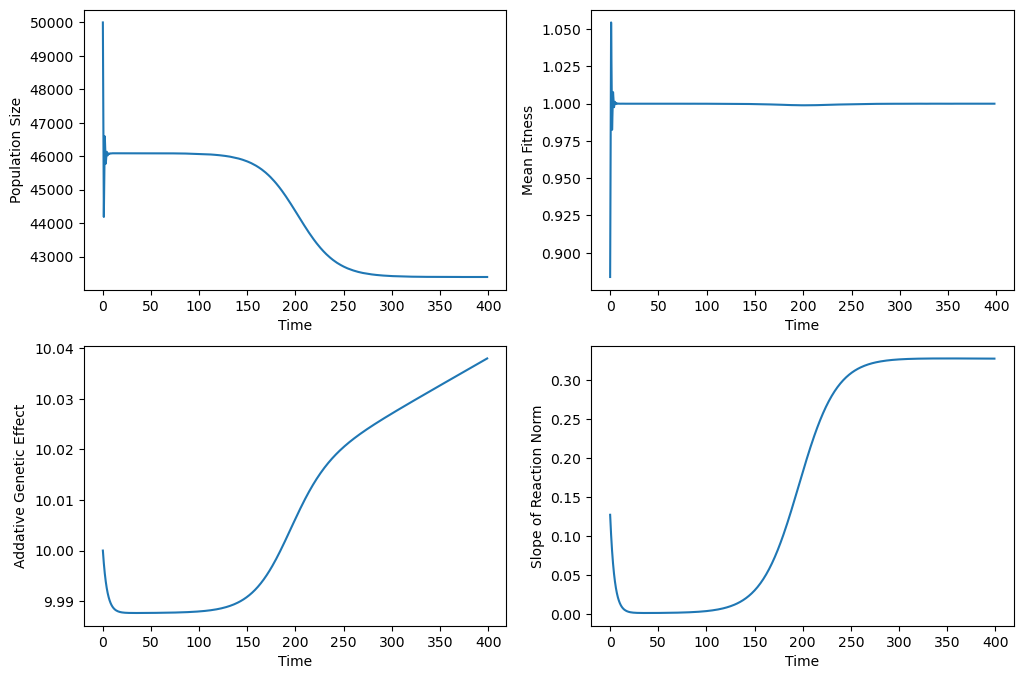

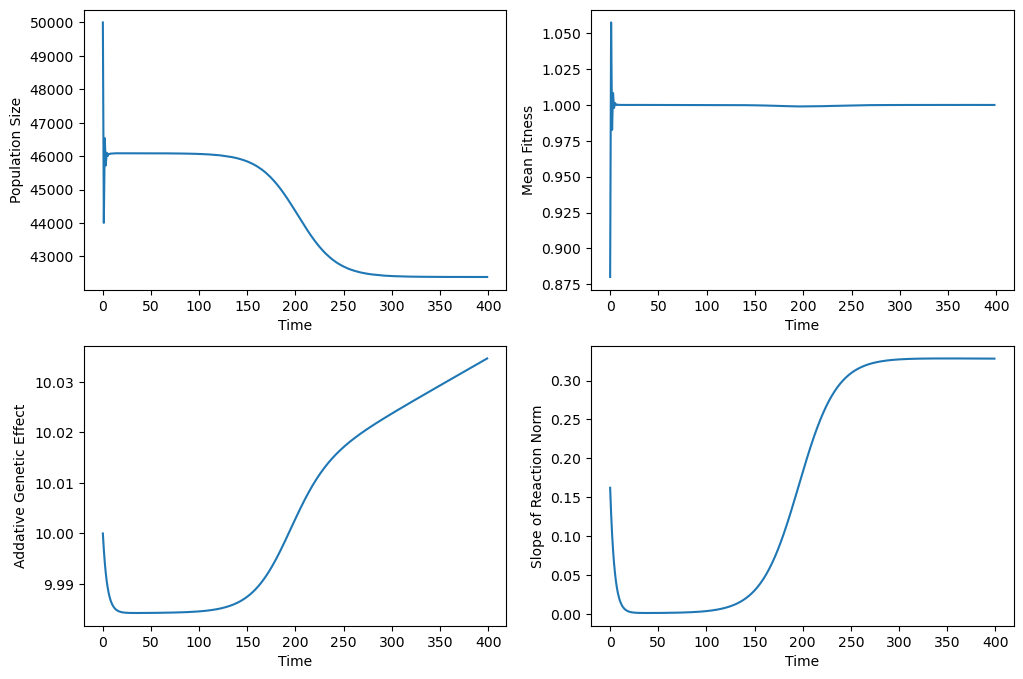

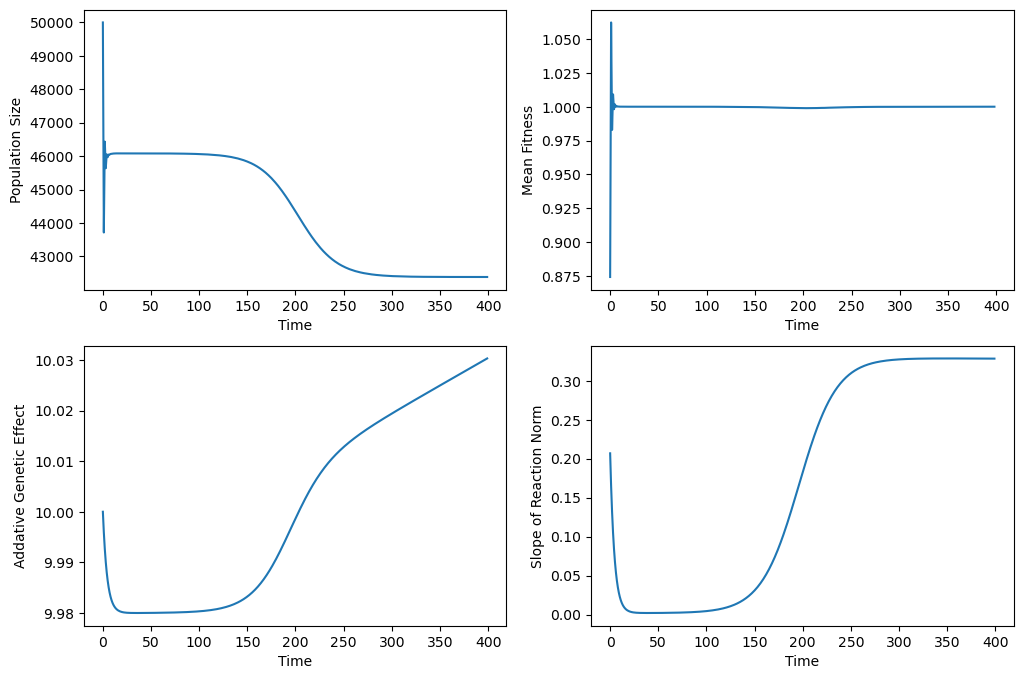

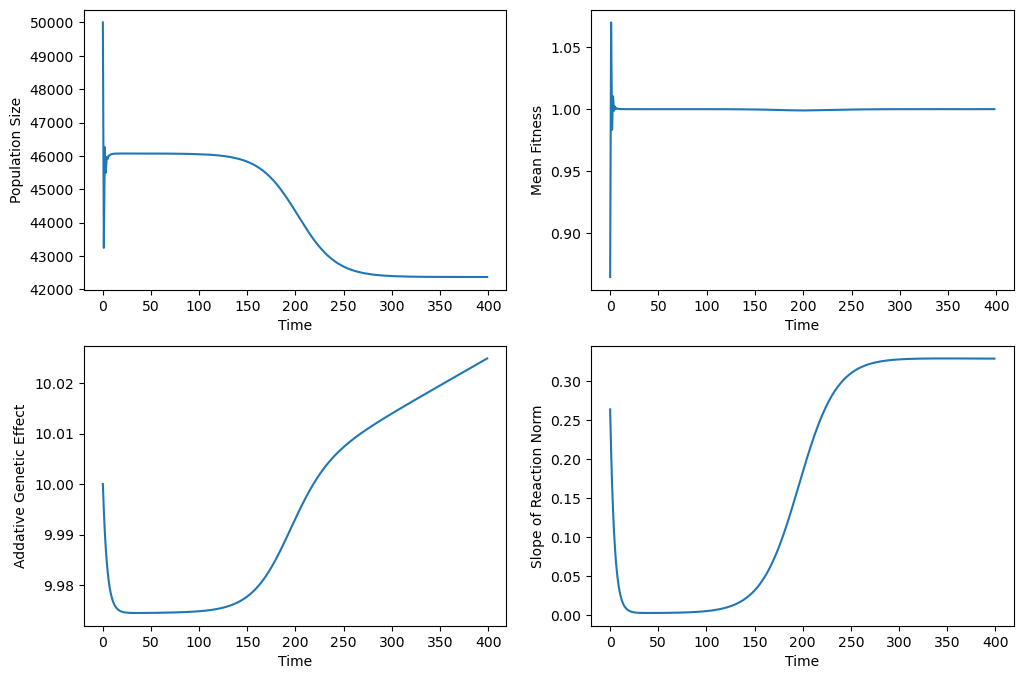

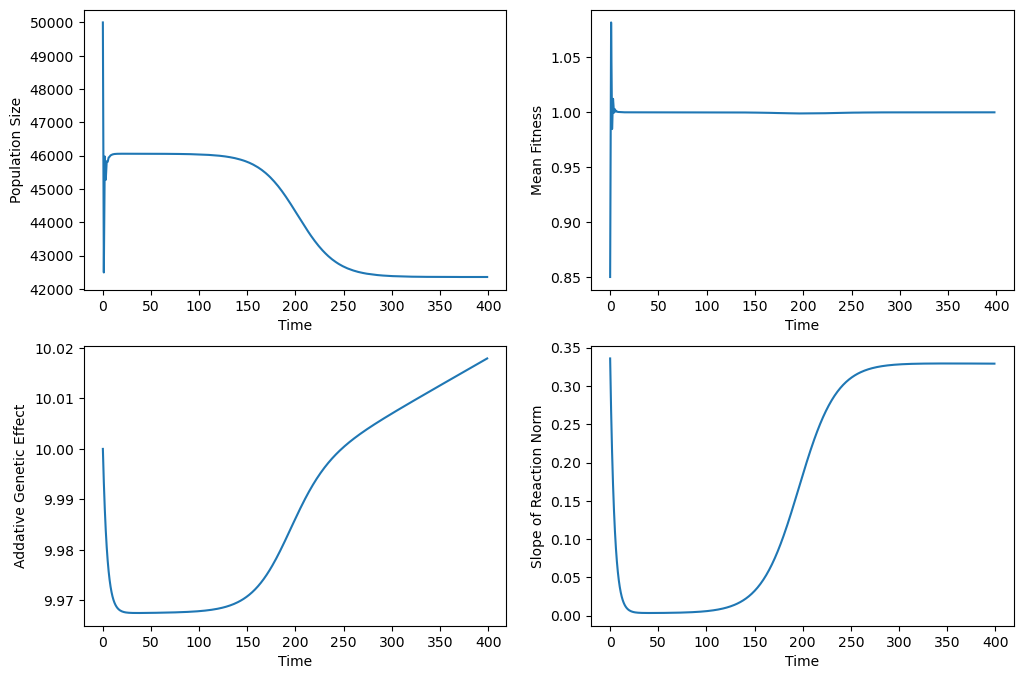

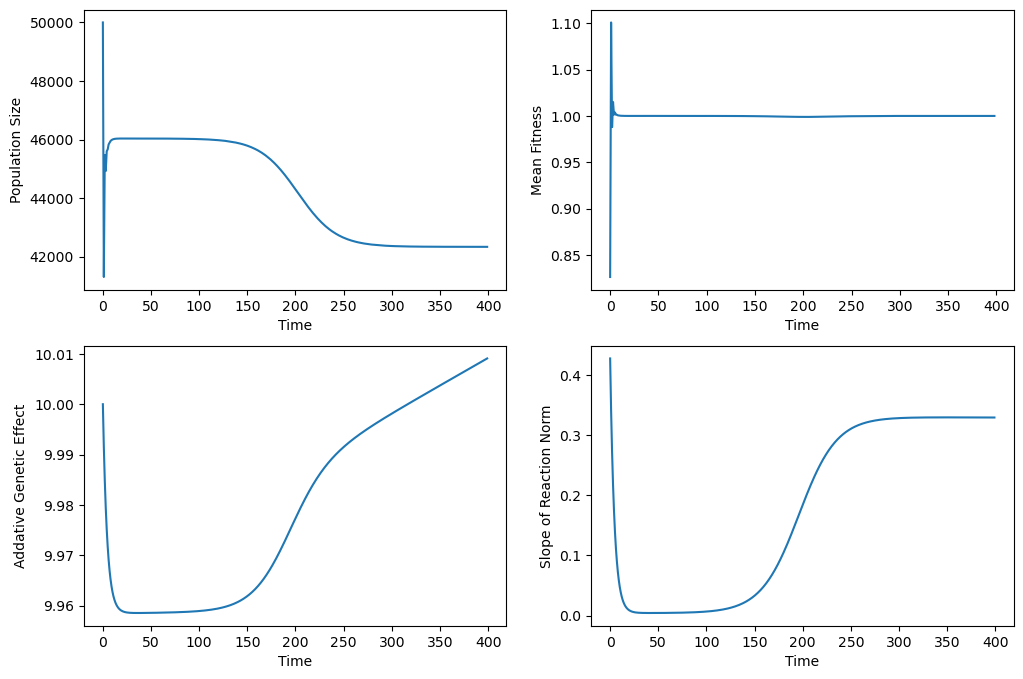

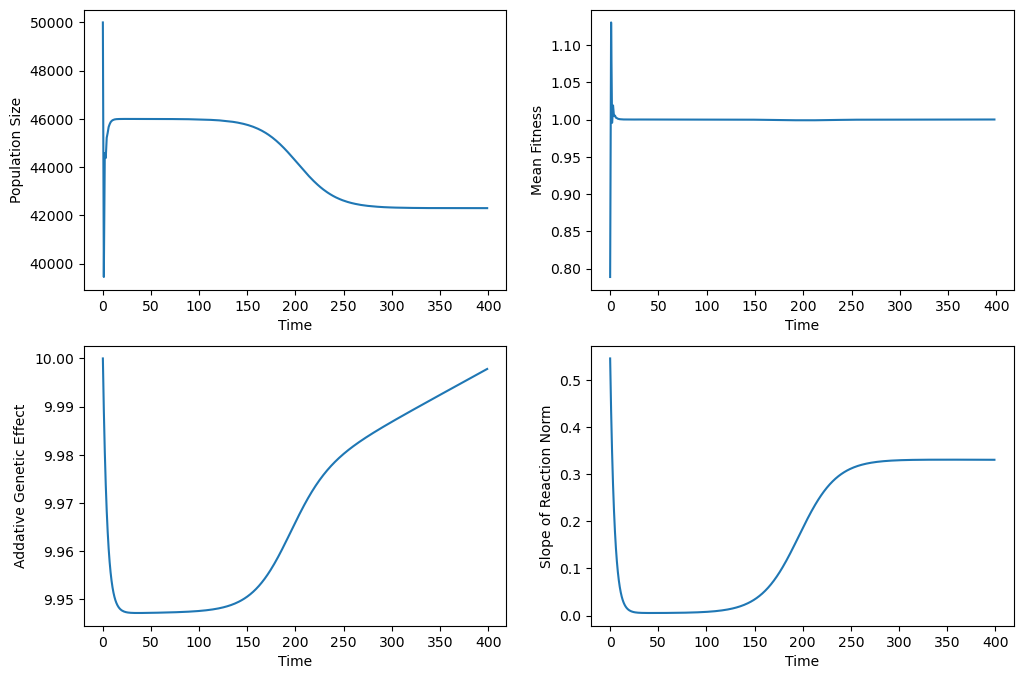

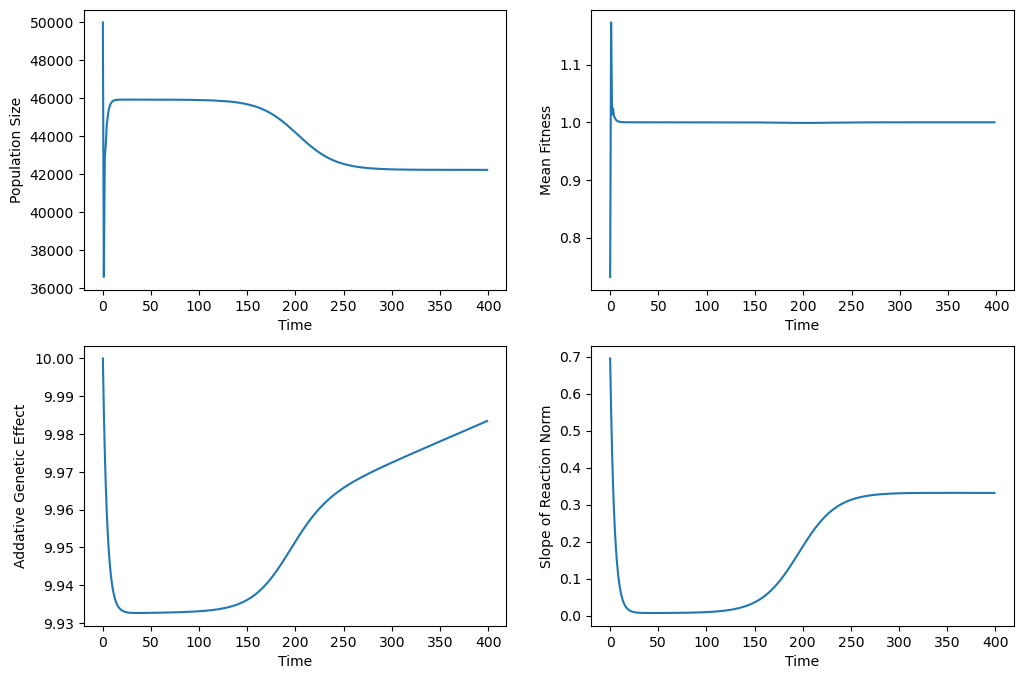

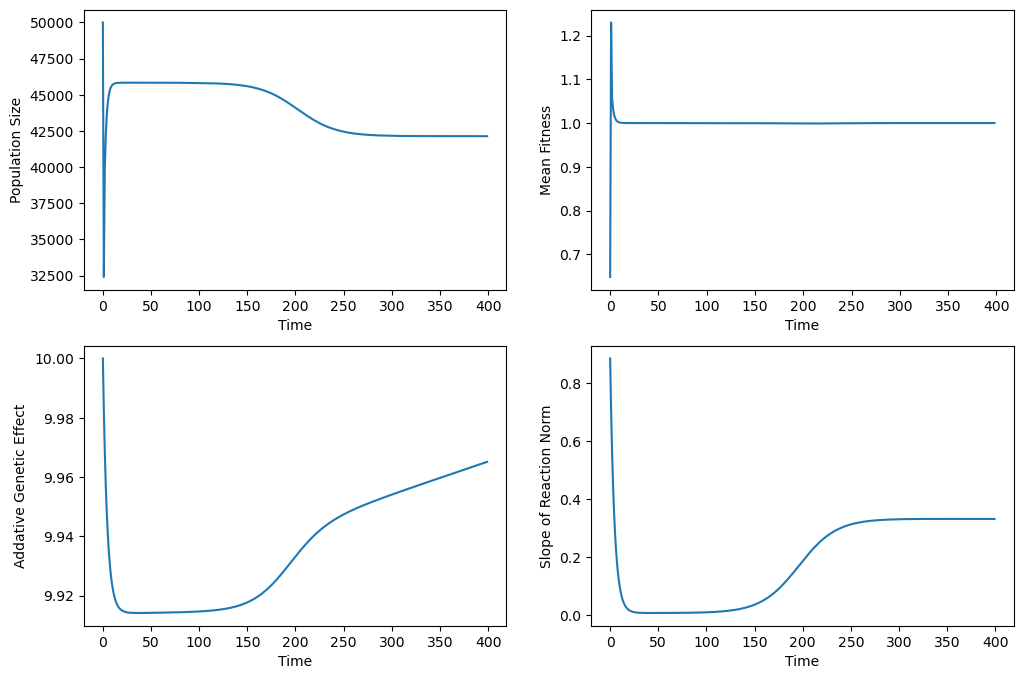

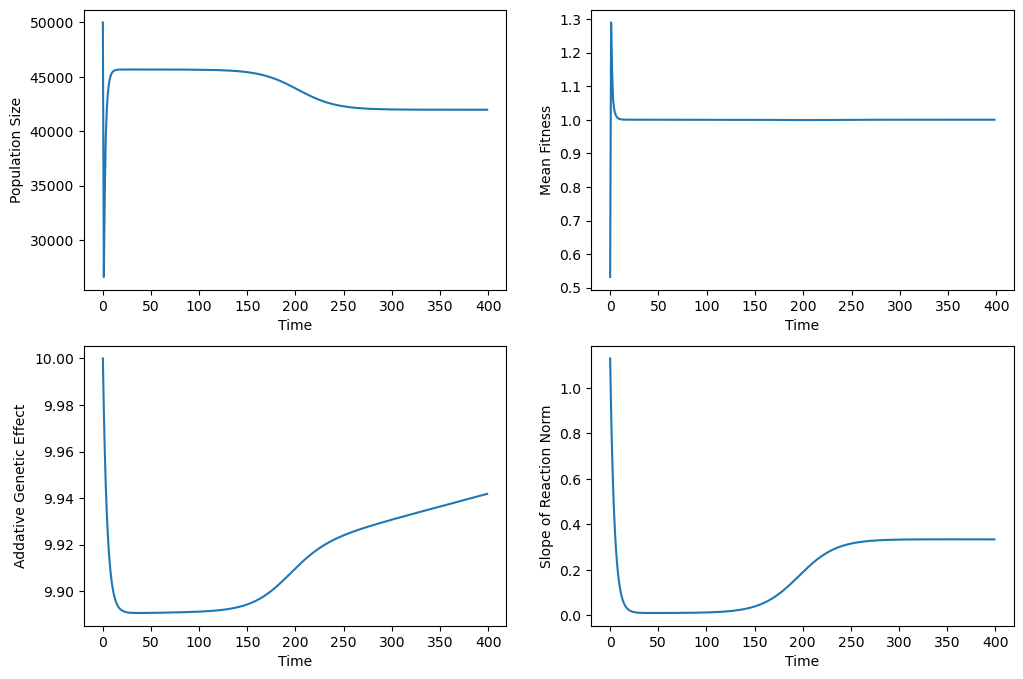

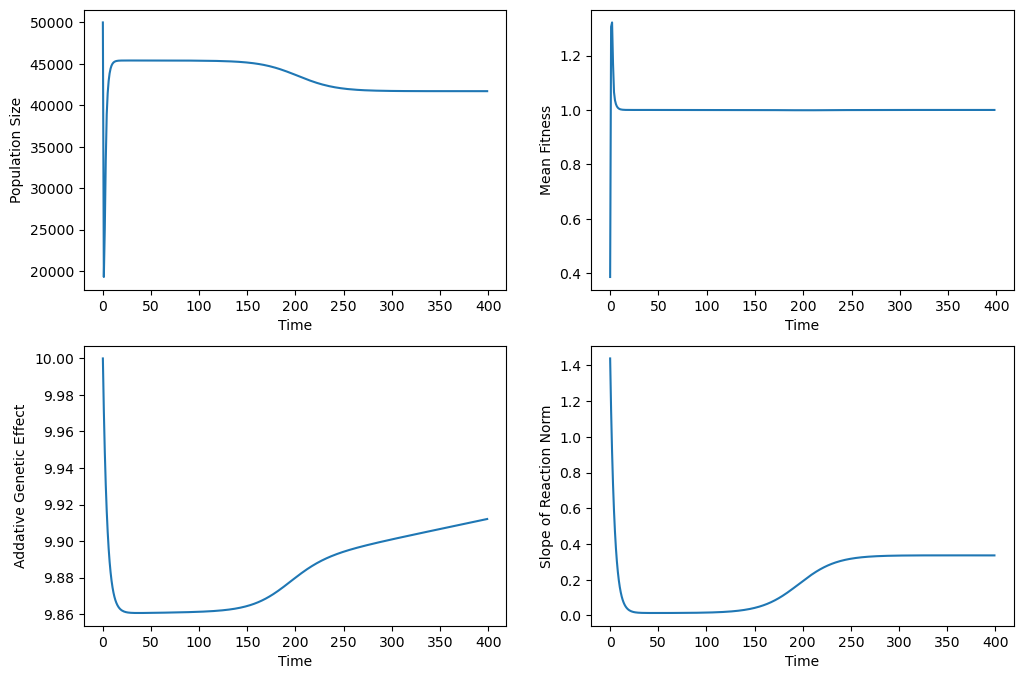

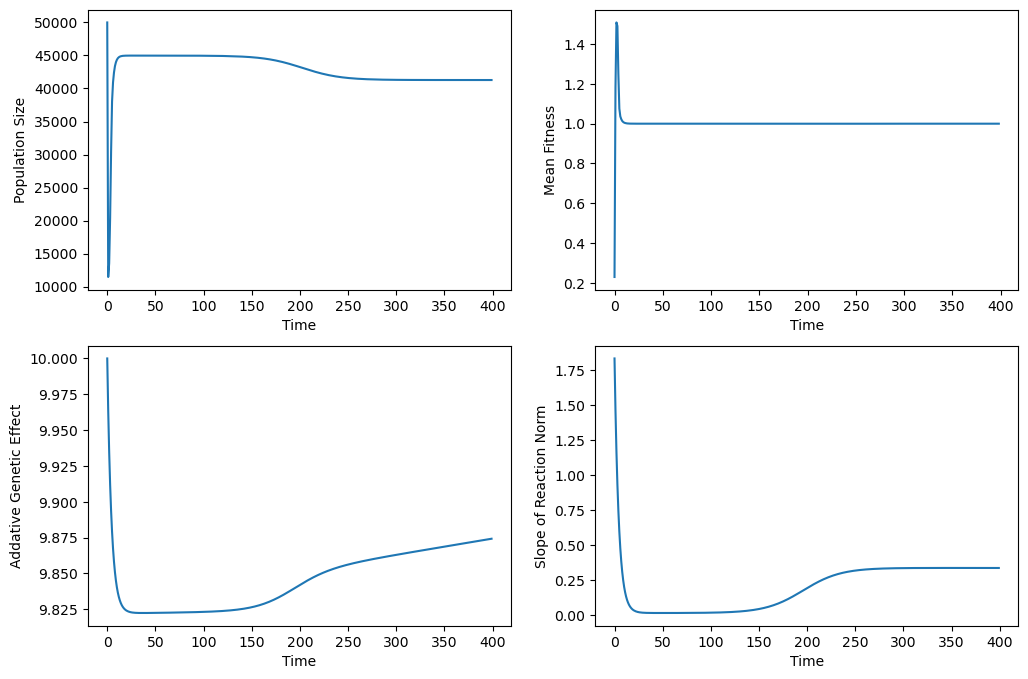

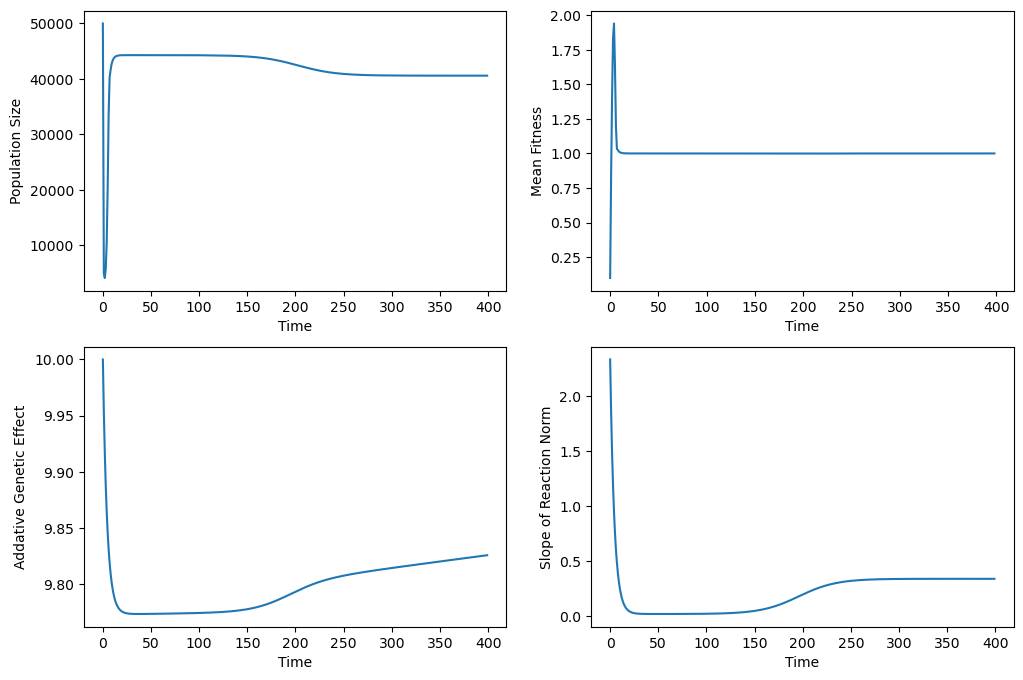

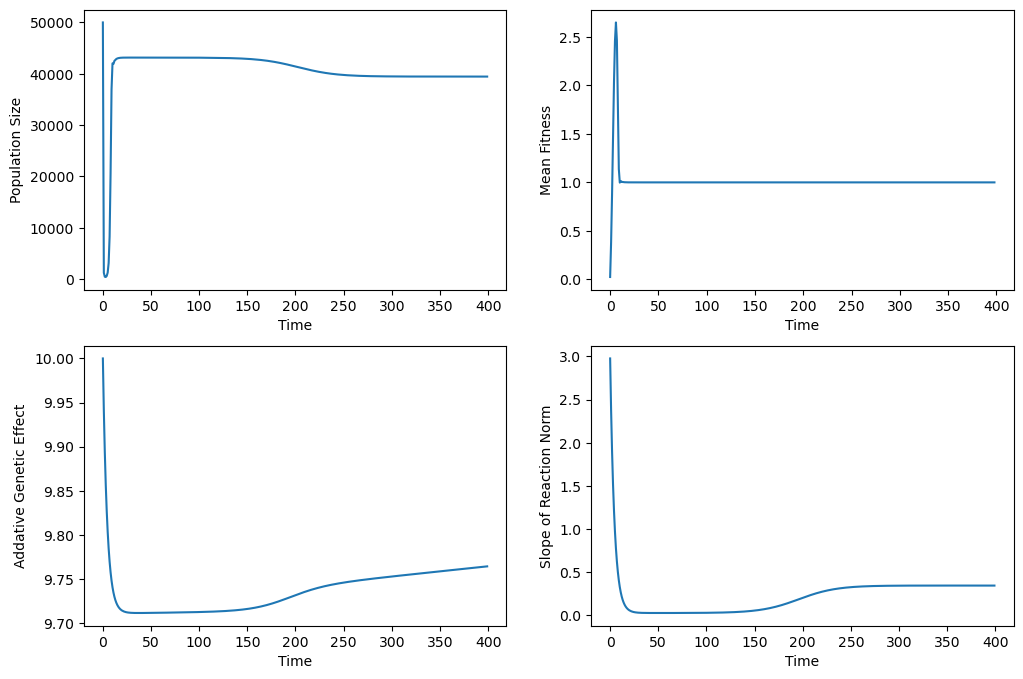

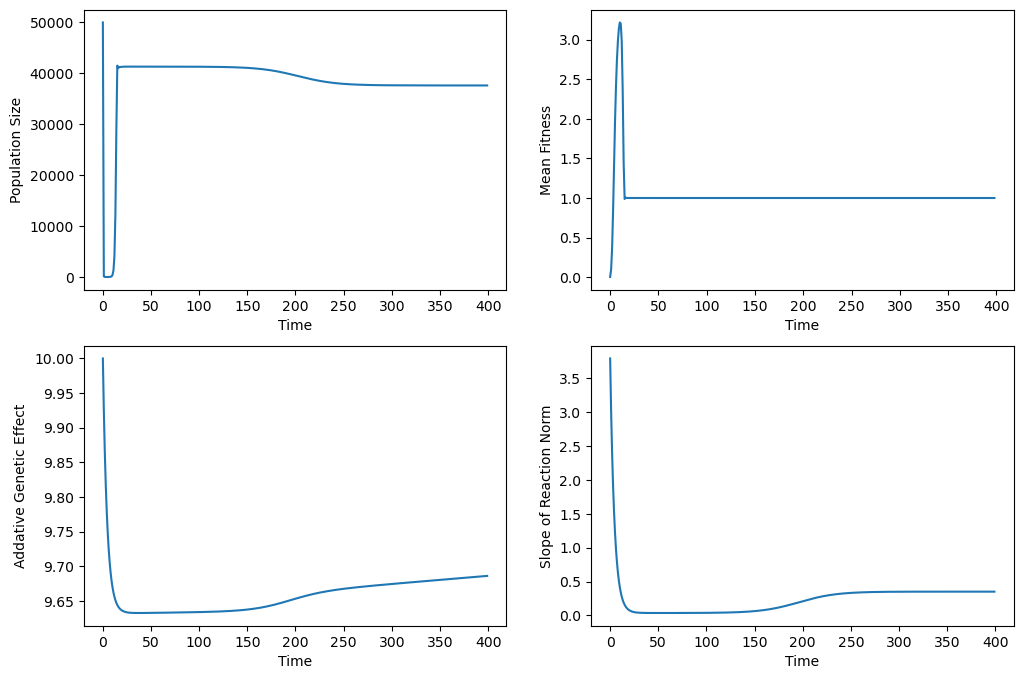

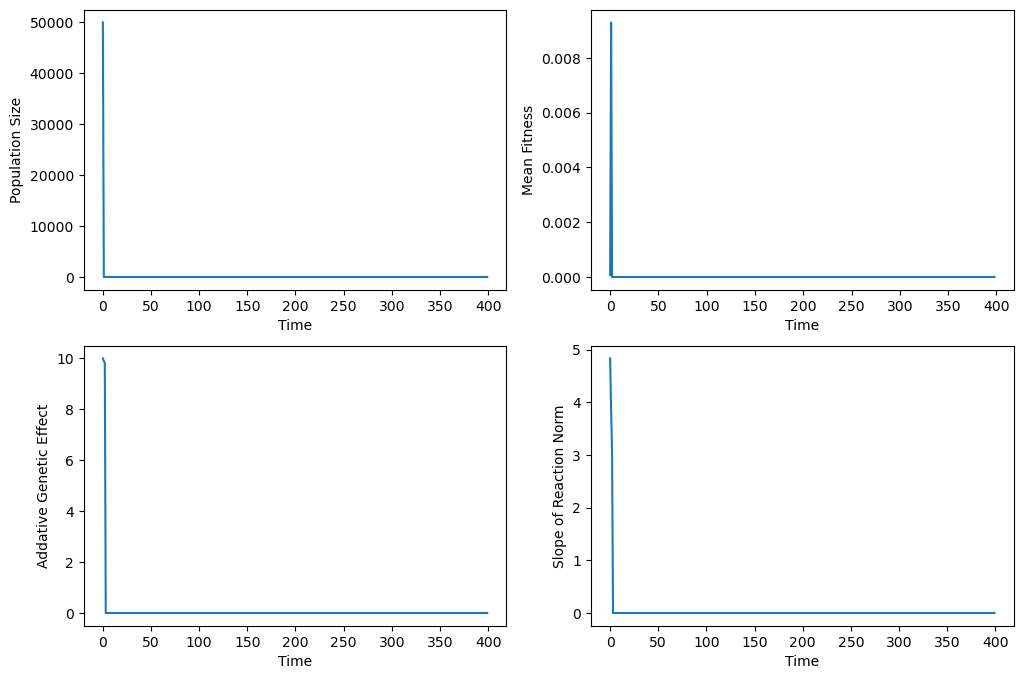

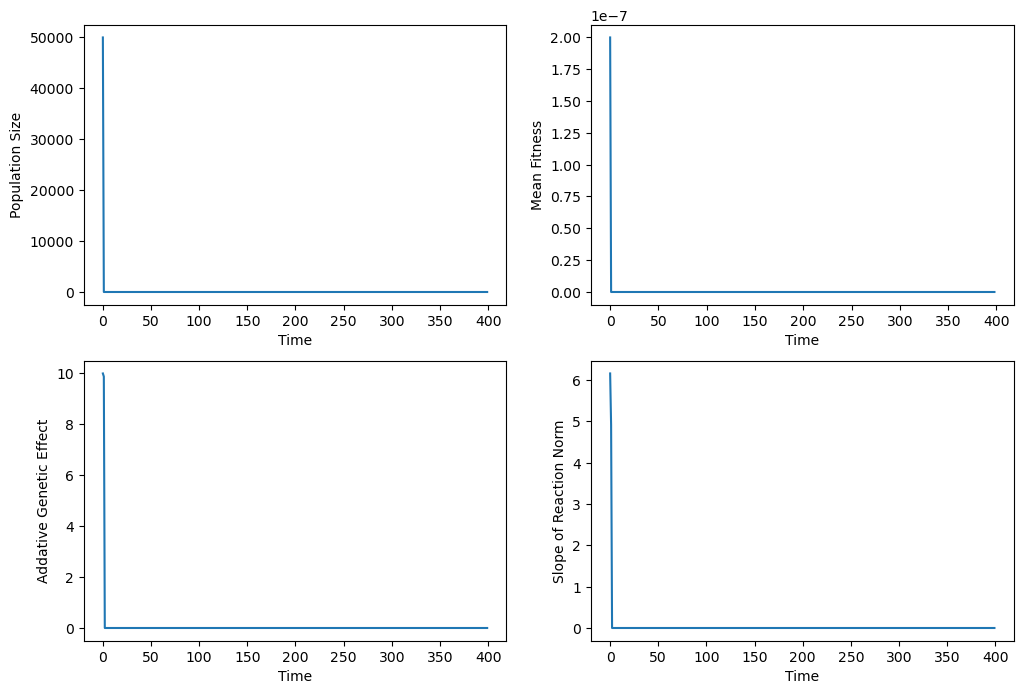

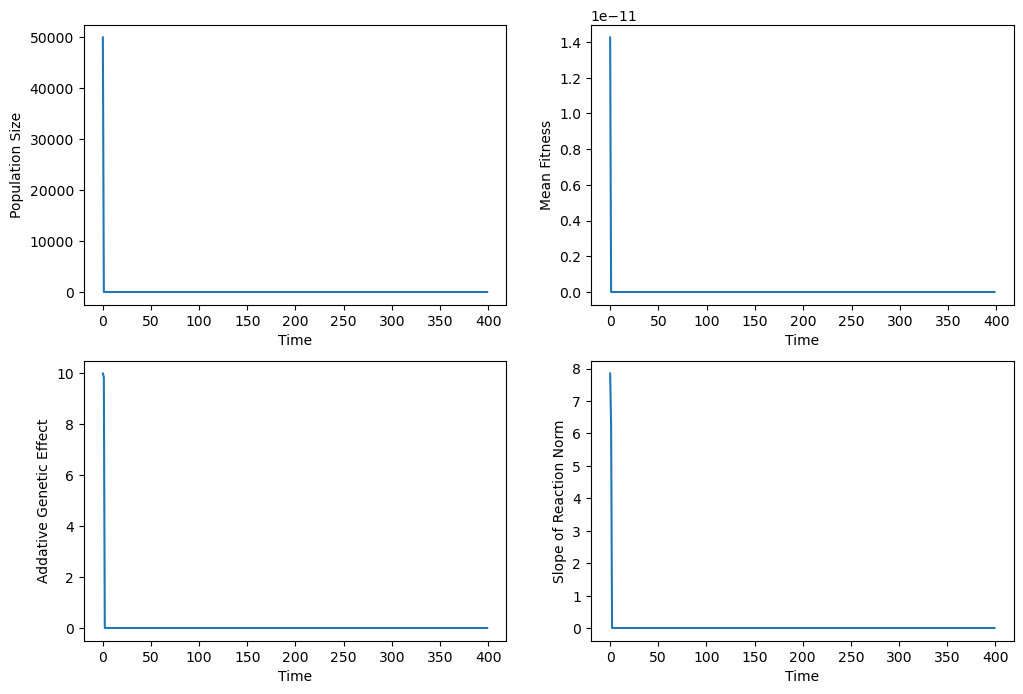

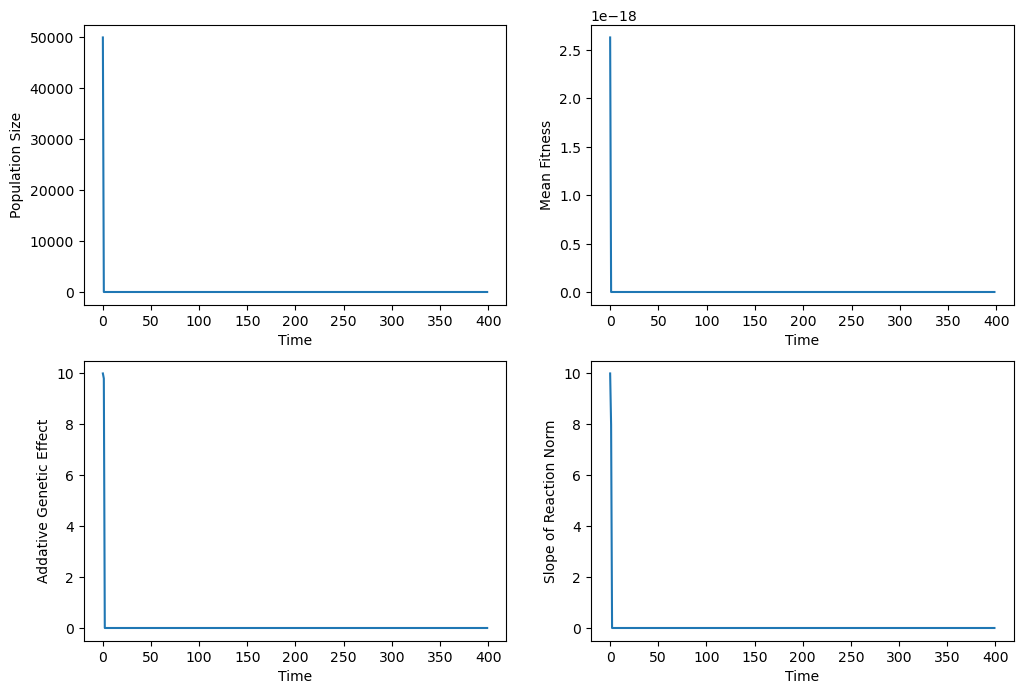

In [201]:
for i in range(plasticity_values.size):
    population_size, mean_fitness, x_trait, b_trait, generations, cost, fitBar = sim_plasticity_evo(
                    pop_size_init = 50000,
                    num_generations = 400,
                    r0 = 4.48, # Upper limmit of per capita reproduction 
                    b_init = plasticity_values[i], # init slope of reaction norm
                    x_init = 10.0, # init intercept of reaction norm
                    beta = 1.0, # environmental sensetivity of phenotypic selection
                    K = 50000, # carrying capacity
                    v_array = x, # slope of environmental variables
                    omegaB = 50, # width of fitness function describing the stabilizing selection on 
                    omegaZ = 100, # width of fitness function describing the stabilizing selection on trait z
                    sigmaB = 0.25, #
                    sigmaX = 0.25, #
                    sigmaE = 0.5  #
                    )
    plot_quad(population_size, mean_fitness, x_trait, b_trait)

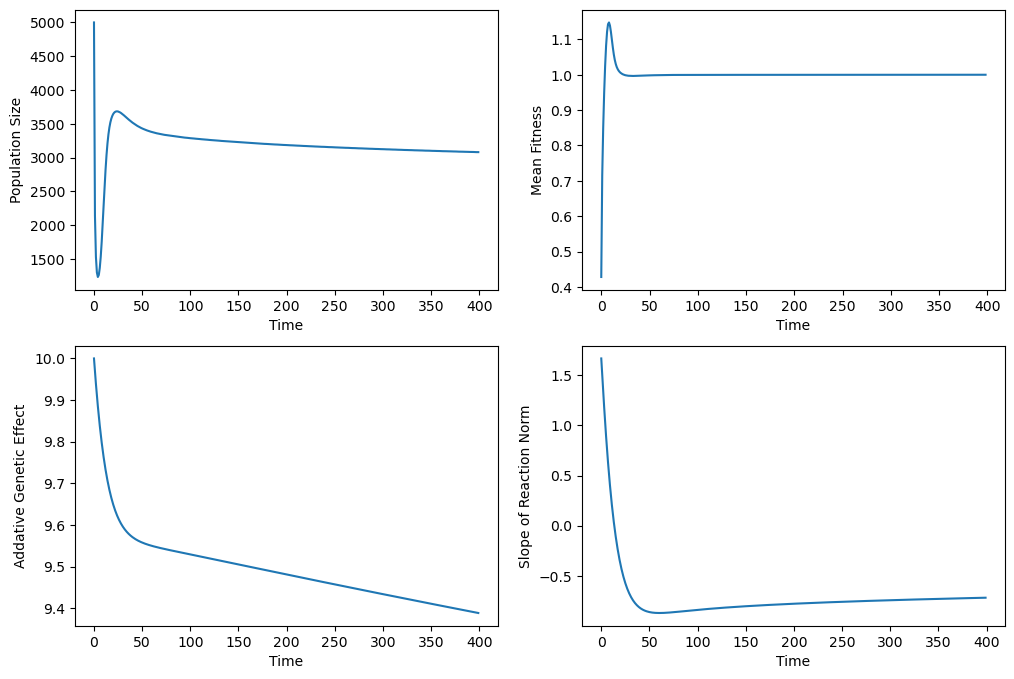

In [190]:
population_size, mean_fitness, x_trait, b_trait, generations, cost, fitBar = sim_plasticity_evo(
                    pop_size_init = 5000,
                    num_generations = 400,
                    r0 = 2.15, # Upper limmit of per capita reproduction 
                    b_init = plasticity_values[5], # init slope of reaction norm
                    x_init = 10.0, # init intercept of reaction norm
                    beta = 0.5, # environmental sensetivity of phenotypic selection
                    K = 5000, # carrying capacity
                    v_array = x, # slope of environmental variables
                    omegaB = 50, # width of fitness function describing the stabilizing selection on 
                    omegaZ = 100, # width of fitness function describing the stabilizing selection on trait z
                    sigmaB = 0.25, #
                    sigmaX = 0.25, #
                    sigmaE = 0.5  #
                    )
plot_quad(population_size, mean_fitness, x_trait, b_trait)